# Compound Floods: Coastal

hourly data
- Wind Data (m/s)
- Tides and Water Level (m)

### NOAA Tides & Currents: extremes in past hour
- Virginia: https://tidesandcurrents.noaa.gov/map/index.html?region=Virginia#
- Yorktown: https://tidesandcurrents.noaa.gov/inventory.html?id=8637689
- Sewells Point: https://tidesandcurrents.noaa.gov/inventory.html?id=8638610
- Gloucester before 2003: https://tidesandcurrents.noaa.gov/inventory.html?id=8637624
- https://pypi.org/project/noaa-coops/
- product: https://api.tidesandcurrents.noaa.gov/api/prod/#products
- datum: https://api.tidesandcurrents.noaa.gov/api/prod/#datum:~:text=for%20the%20station-,Datum,-The%20datum%20can
- Output columns: https://api.tidesandcurrents.noaa.gov/api/prod/responseHelp.html
- https://maps.waterdata.usgs.gov/mapper/index.html

- dates of active stations are from (first available day) to (at most day of download)

### Meteostat: measurements at end of each hour
- https://dev.meteostat.net/python/daily.html#data-structure
- Variables and units: https://dev.meteostat.net/formats.html
- Station data columns: https://dev.meteostat.net/python/stations.html#data-structure

### Example: 2016
- September 2-3, 2016 Tropical Storm Hermine https://www.weather.gov/mhx/hermine_090216
- September 11 – 23, 2016: Tropical Storm Julia https://www.wpc.ncep.noaa.gov/tropical/rain/julia2016.html
- October 8, 2016: Hurricane Matthew https://www.weather.gov/ilm/matthew

### Other variables
- pressure?



In [1]:
# !pip install noaa_coops
# !pip install meteostat

import os
import glob
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from meteostat import Stations, Point, Daily, Hourly
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import matplotlib.dates as mdates
import noaa_tc

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 4)
plt.rcParams['figure.dpi'] = 200 # 300
plt.rcParams['font.size'] = 10
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['axes.linewidth'] = 0.1
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['grid.linewidth'] = 0.1

output_dir = 'data'

# stations = [8637689, 8638610, 8638901, 8638614, 8638511, 8637624, 8638595]
# noaa_tc.get_stations(stations, output_dir)

# # Process wind data
# noaa_tc.process_wind_data(wind, output_dir)
# wind_data = noaa_tc.aggregate_wind_data(wind_stations, output_dir)

# # Process water data
# noaa_tc.process_water_data(water, output_dir)
# water_data = noaa_tc.aggregate_water_data(water_stations, output_dir)

# met_stations = Stations().nearby(37.0862, -76.3809).fetch(10)
# met_stations = met_stations[met_stations.distance <= 30000] #km
# met_stations.to_csv(f'{output_dir}/meteo.csv')

# for station_id, row in met_stations.iterrows():
#     print(station_id)
#     dd = Hourly(station_id, row.hourly_start, row.hourly_end).fetch()
#     dd = dd.dropna(axis=1, how='all')
#     dd.to_parquet(f'{output_dir}/meteo.{station_id}.parquet')

# meteo = pd.read_csv(f'{output_dir}/meteo.csv')
# meteo_df = []
# for station_id in meteo.id:
#     print(station_id)
#     dd = (pd.read_parquet(f'{output_dir}/meteo.{station_id}.parquet')[['prcp', 'wdir', 'wspd']]
#           .dropna(how='all').rename(columns={'prcp':'pr', 'wdir':'dir', 'wspd': 'speed'}))
#     dd.speed = dd.speed / 3.6 # km/h to m/s
#     # display(round(dd.describe().T, 1))
#     meteo_df.append(dd.add_suffix(f'_{station_id}'))
# meteo_df = pd.concat(meteo_df, axis=1)
# meteo_df.to_parquet(f'{output_dir}/meteo.pr_wind.parquet')

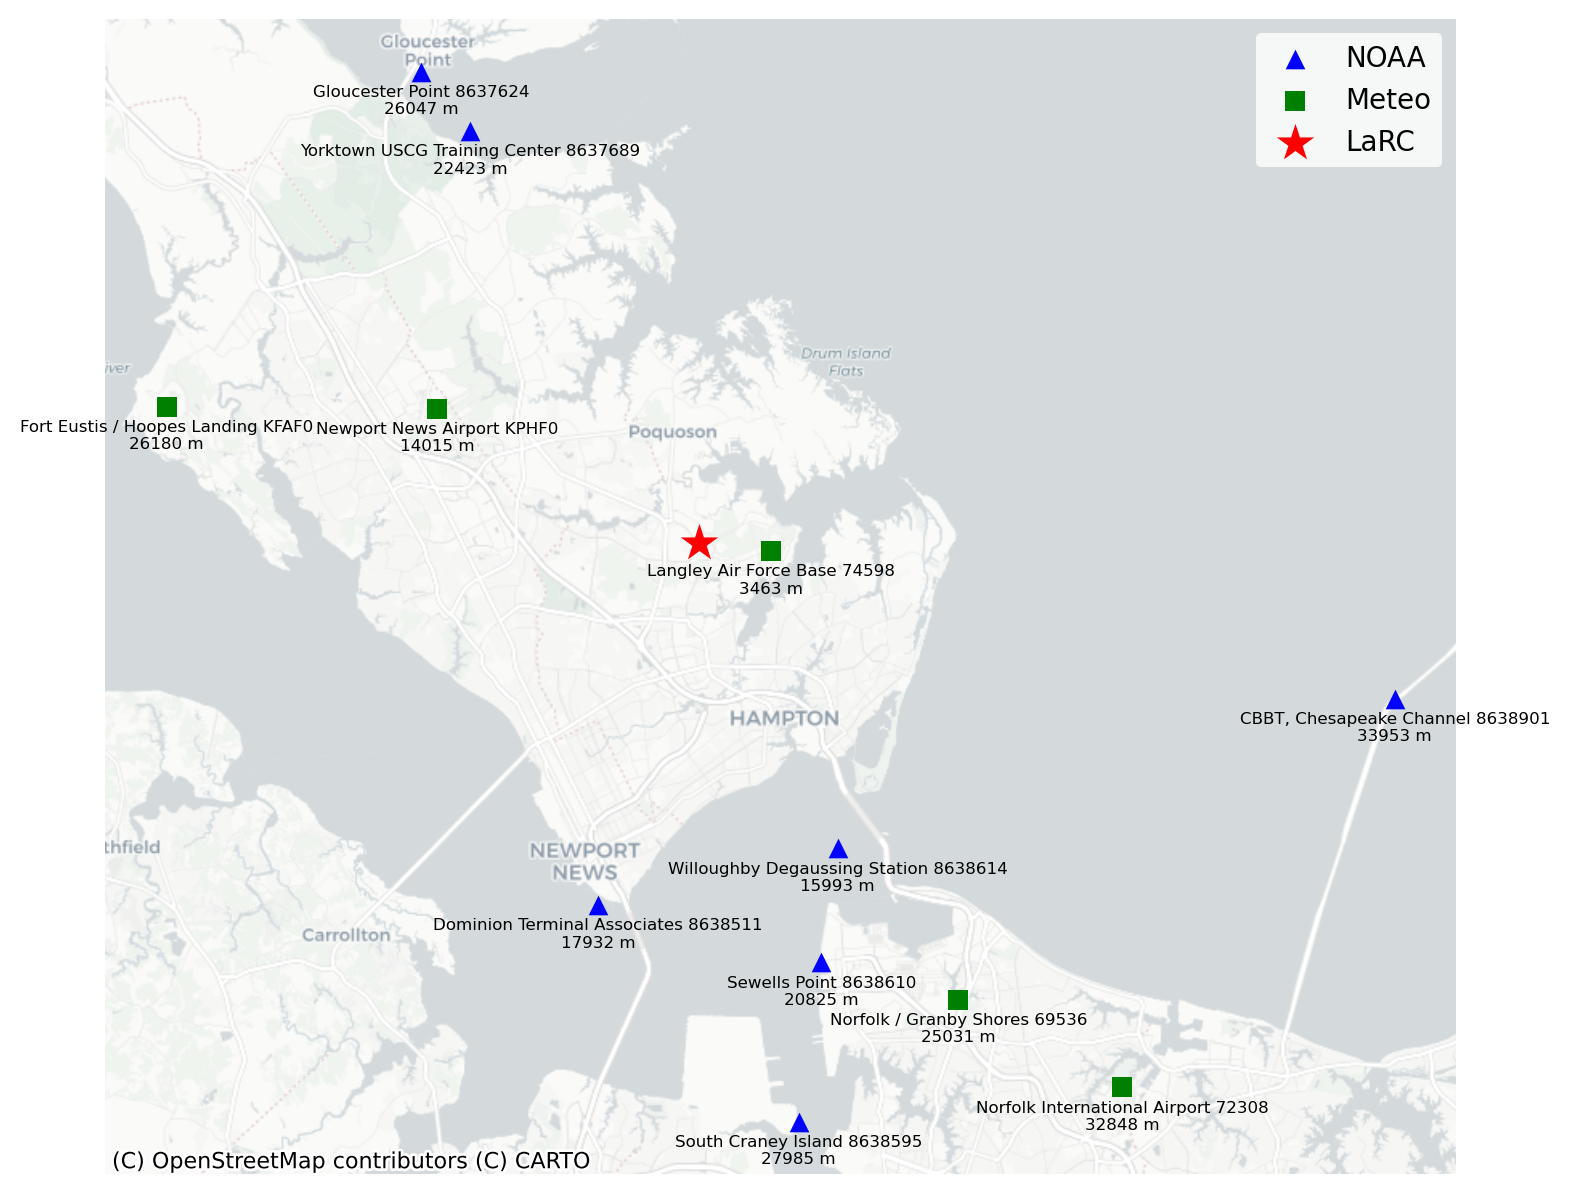

In [2]:
noaa = pd.read_csv(f'{output_dir}/noaa_tc.csv')
noaa.station_id = noaa.station_id.astype(str)
noaa[['start_date', 'end_date']] = noaa[['start_date', 'end_date']].apply(pd.to_datetime)
noaa['station'] = noaa.station_name + ' ' + noaa.station_id
wind = noaa[noaa.variable=='Wind']
water = noaa[noaa.variable=='Verified 6-Minute Water Level']
wind_stations, water_stations = wind.station_id.values, water.station_id.values

meteo = pd.read_csv(f'{output_dir}/meteo.csv').rename(columns={'latitude': 'lat', 'longitude':'lon'})
meteo[['hourly_start', 'hourly_end']] = meteo[['hourly_start', 'hourly_end']].apply(pd.to_datetime)
meteo['station'] = meteo.name + ' ' + meteo.id


# Station Map
ref = gpd.GeoSeries([Point(-76.3809, 37.0862)], crs='EPSG:4326').to_crs(3857)
fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
for dd, color, marker, label in [(noaa, 'blue', '^', 'NOAA'), (meteo, 'green', 's', 'Meteo')]:
    df = (gpd.GeoDataFrame(dd, geometry=gpd.points_from_xy(dd.lon, dd.lat), crs='EPSG:4326').to_crs(3857)
          .drop_duplicates(subset=['station', 'lat', 'lon']))
    df['distance'] = df.geometry.distance(ref[0])
    df.plot(ax=ax, color=color, marker=marker, markersize=50, label=label)
    df.apply(lambda r: ax.text(r.geometry.x, r.geometry.y - 2000, f'{r.station}\n{r.distance:.0f} m', 
                               fontsize=6, ha='center'), axis=1)
ref.plot(ax=ax, color='red', marker='*', markersize=200, label='LaRC')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [3]:
wind_df = pd.read_parquet(f'{output_dir}/noaa_tc.wind.parquet')
water_df = pd.read_parquet(f'{output_dir}/noaa_tc.water.parquet')
meteo_df = pd.read_parquet(f'{output_dir}/meteo.pr_wind.parquet').drop(columns=['speed_69536'])
df = pd.concat([wind_df, water_df, meteo_df], axis=1)
df = df[sorted(df.columns)][df.index.year >= 1950]

def mask_sparse_years(df, min_obs=31):
    sparse_mask = df.notna().groupby(df.index.year).sum() < min_obs
    year_index = df.index.year.values
    mask = np.zeros_like(df.values, dtype=bool)
    for col_idx, col in enumerate(df.columns):
        for year_idx, year in enumerate(sparse_mask.index):
            if sparse_mask.iloc[year_idx, col_idx]:
                mask[year_index == year, col_idx] = True

    return df.mask(mask)

df = mask_sparse_years(df)

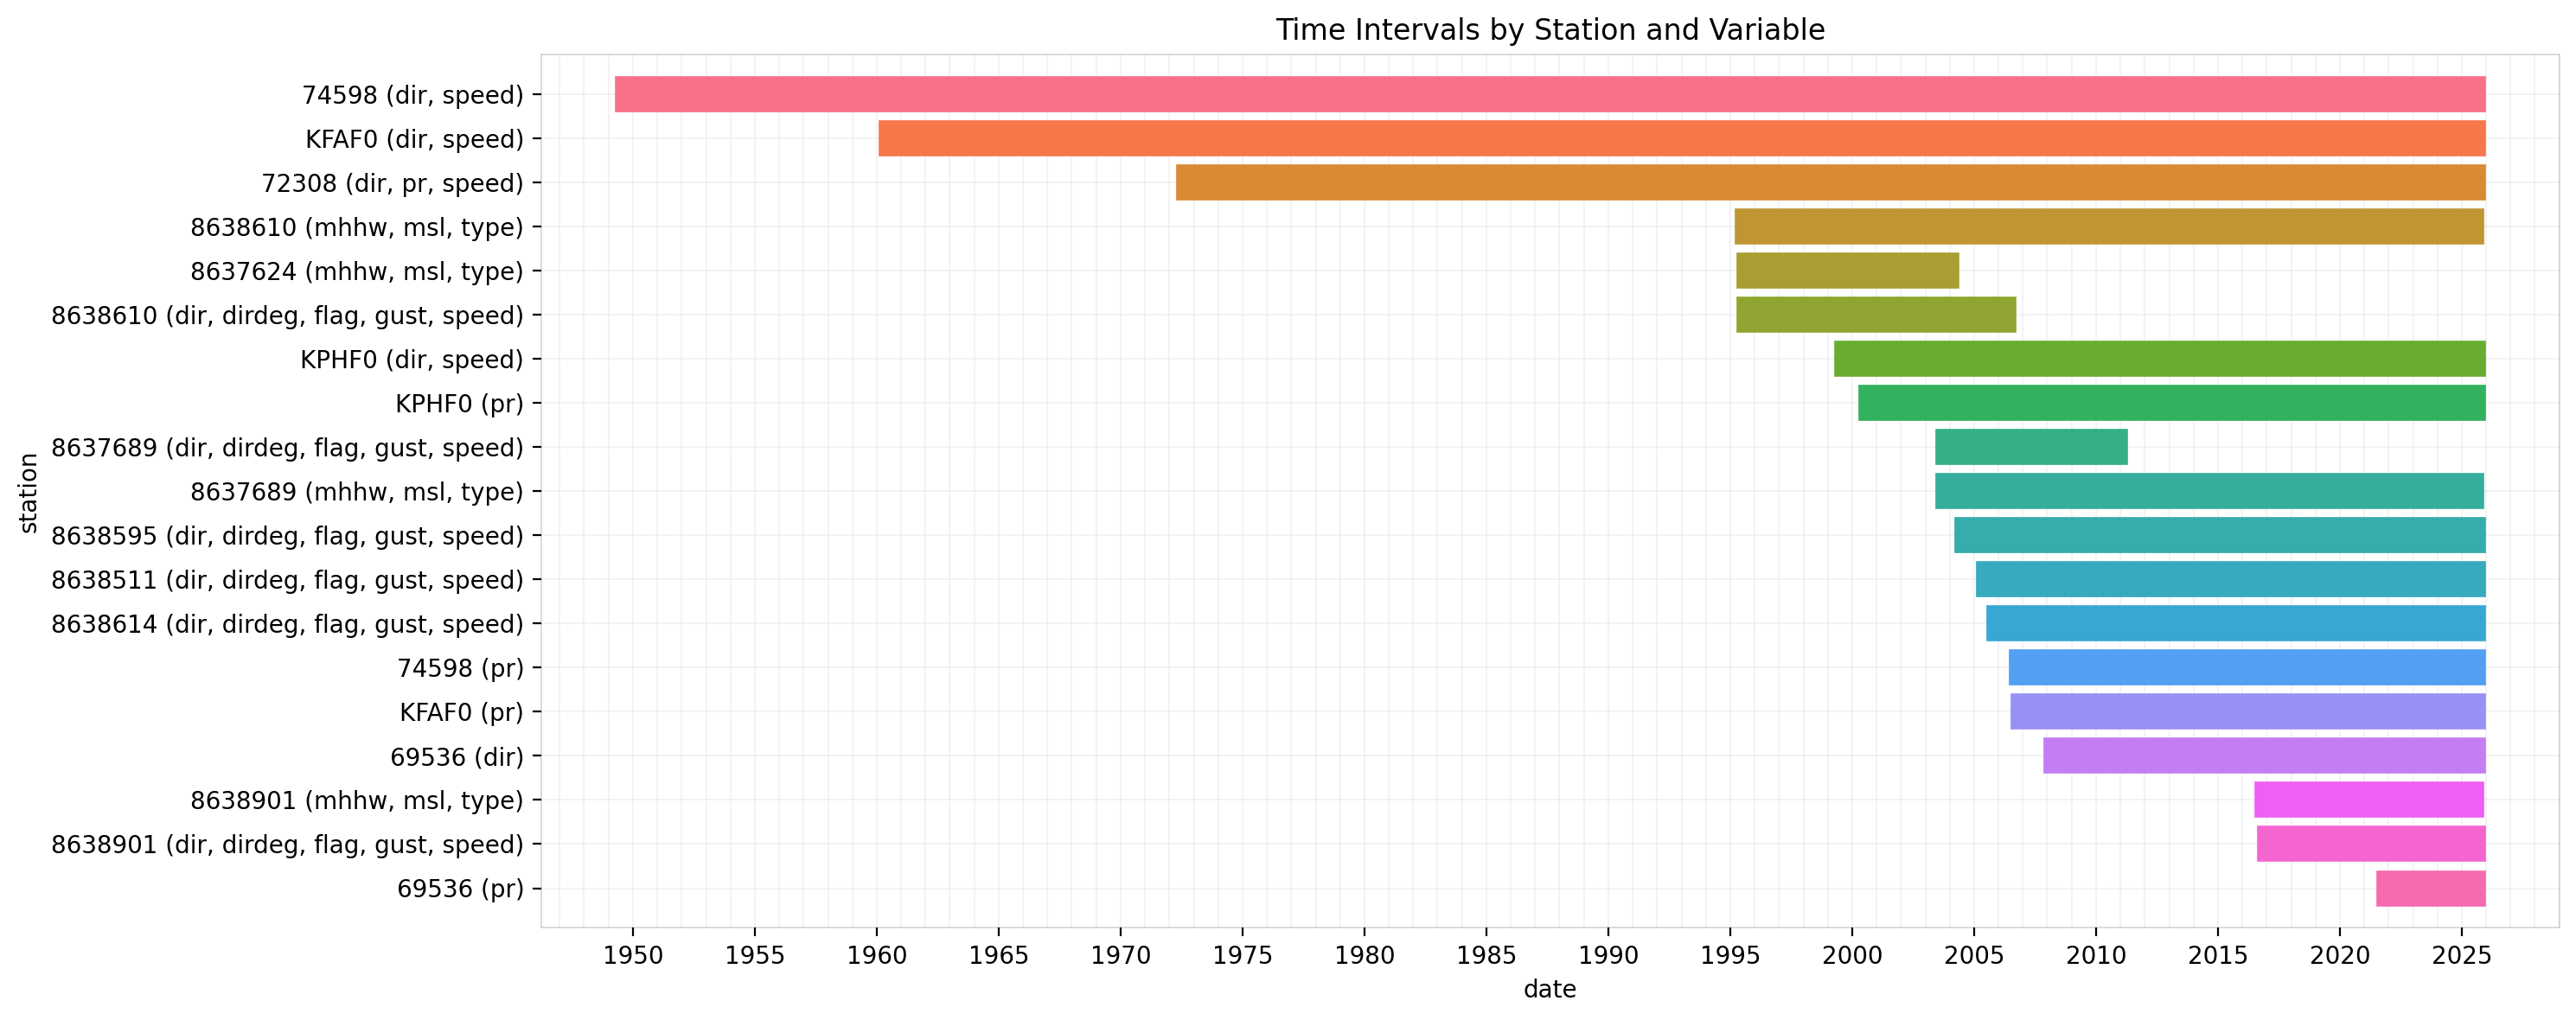

In [4]:
def get_time_intervals(df):    
    res = pd.DataFrame(
        [{'prefix': p, 'station': s, 'start_date': vals.index.min(), 'end_date': vals.index.max()}
         for c in df.columns if not (vals := df[c].dropna()).empty for p, s in [c.split('_', 1)]
    ])
    res[['start_date', 'end_date']] = res[['start_date', 'end_date']].apply(lambda x: x.dt.strftime('%Y-%m'))
    res = res.groupby(['station', 'start_date', 'end_date']).agg(
        lambda x: ', '.join(sorted(set(x)))).reset_index()
    res['station'] = res['station'] + ' (' + res['prefix'] + ')'
    return res.sort_values(['start_date', 'station'])

def plot_time_intervals(df, title=None):
    df = df.melt(id_vars=['station', 'prefix'], value_vars=['start_date', 'end_date'], 
                 var_name='type', value_name='date')
    df.date = pd.to_datetime(df.date)
    
    plt.figure(figsize=(15, 6))
    ax = sns.lineplot(data=df, x='date', y='station', hue='station', lw=15, legend=False)
    ax.set(title=title)
    ax.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', which='minor', length=0)
    ax.grid(which='both', linewidth=0.1)
    plt.tight_layout(); plt.show()
    
    return df

# might have date gaps between
plot_data = plot_time_intervals(get_time_intervals(df), title='Time Intervals by Station and Variable')

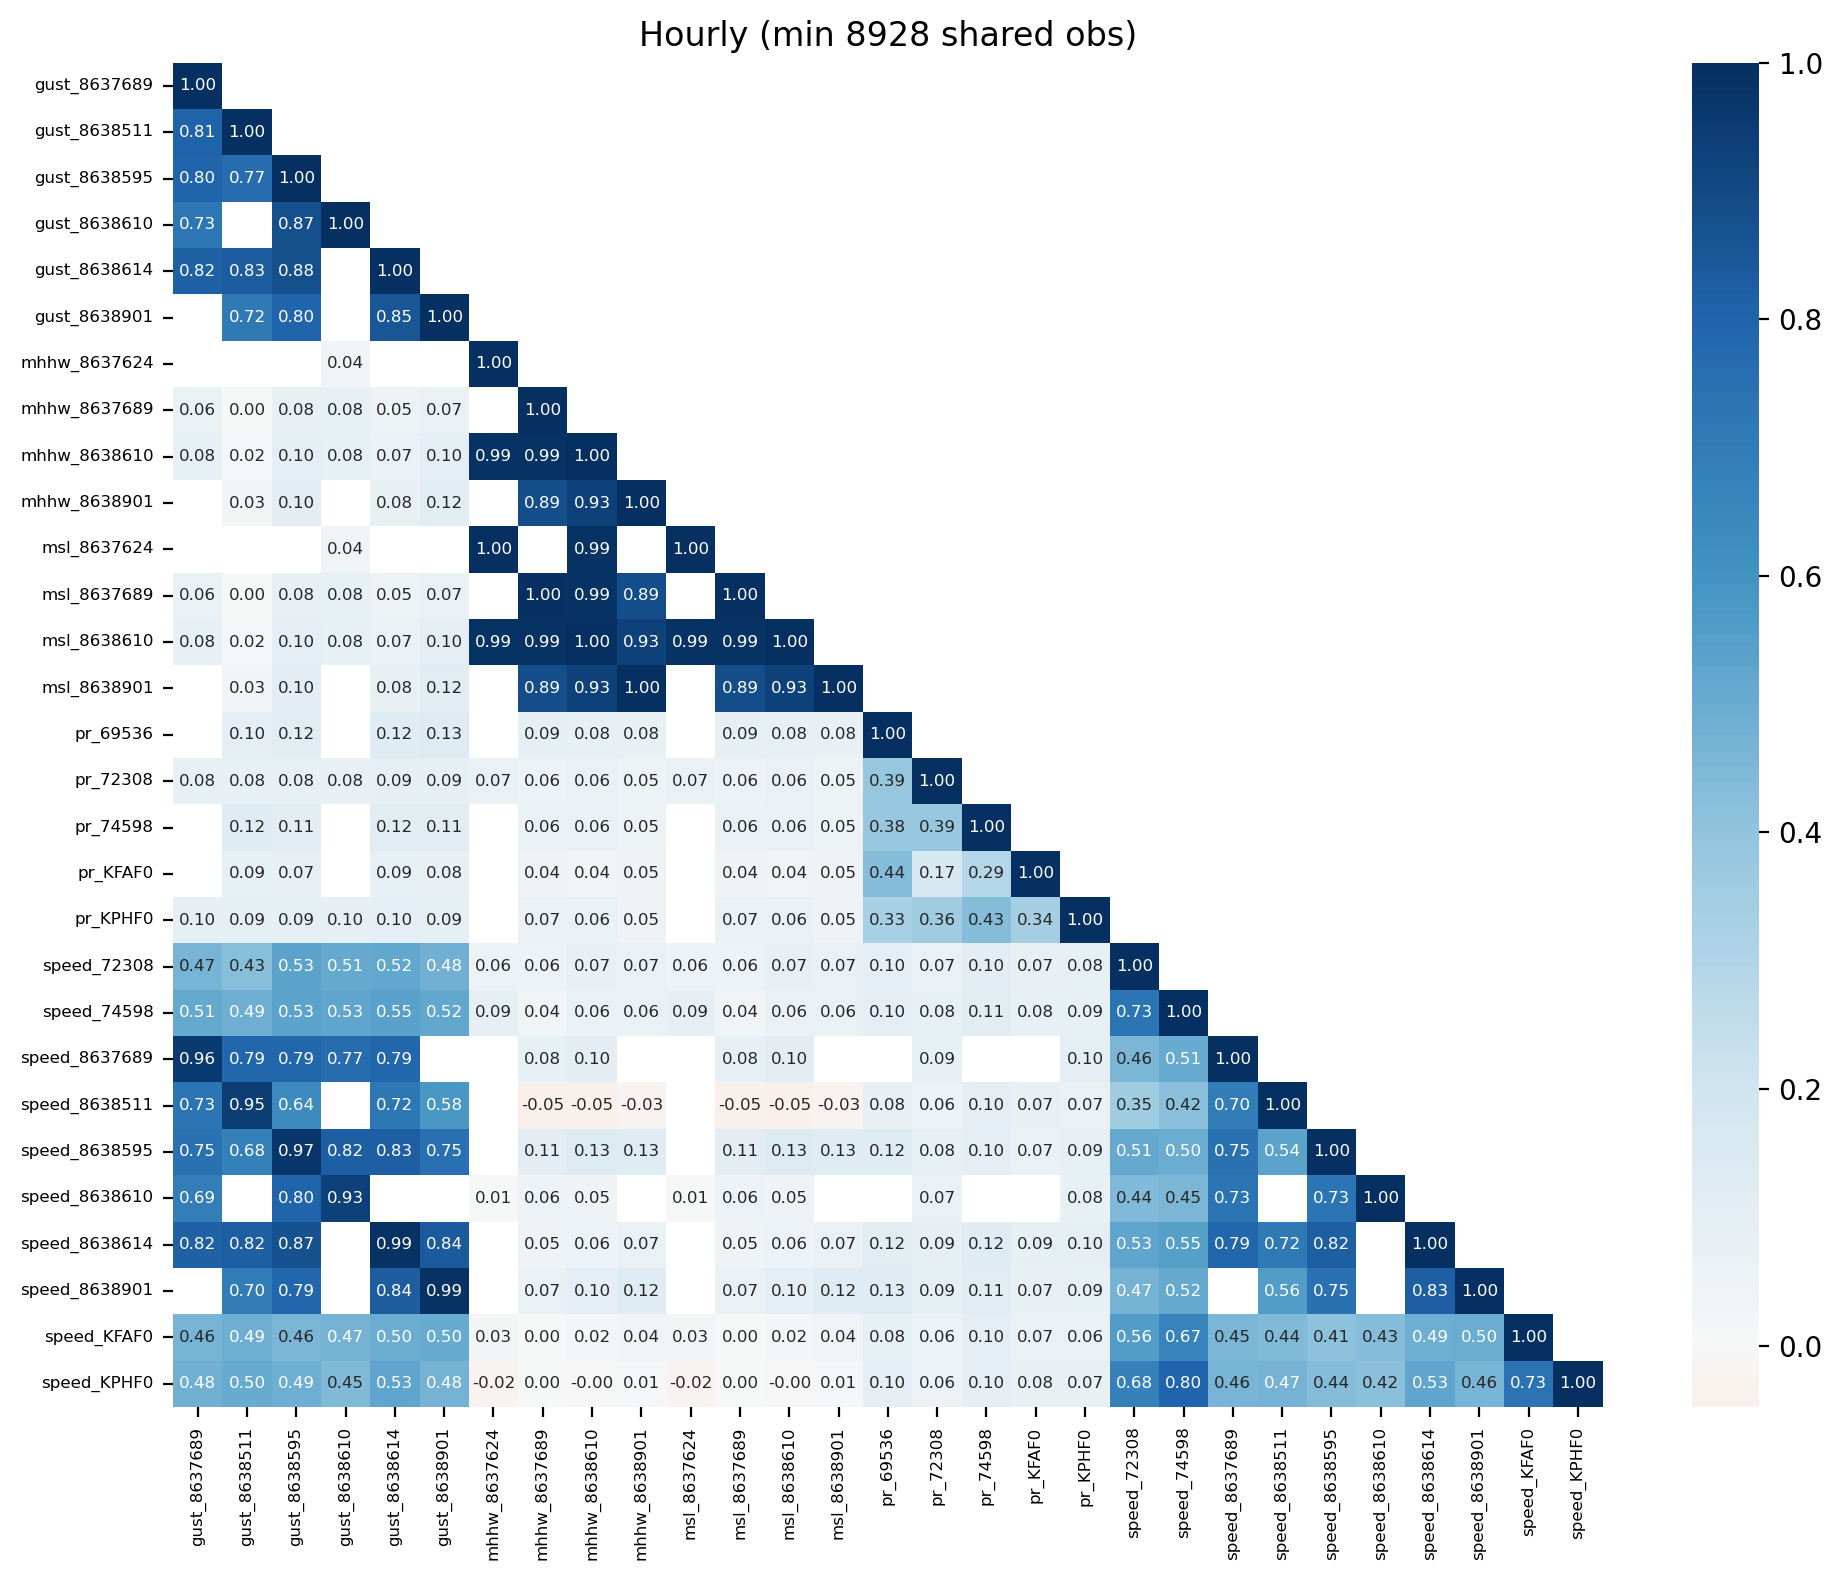

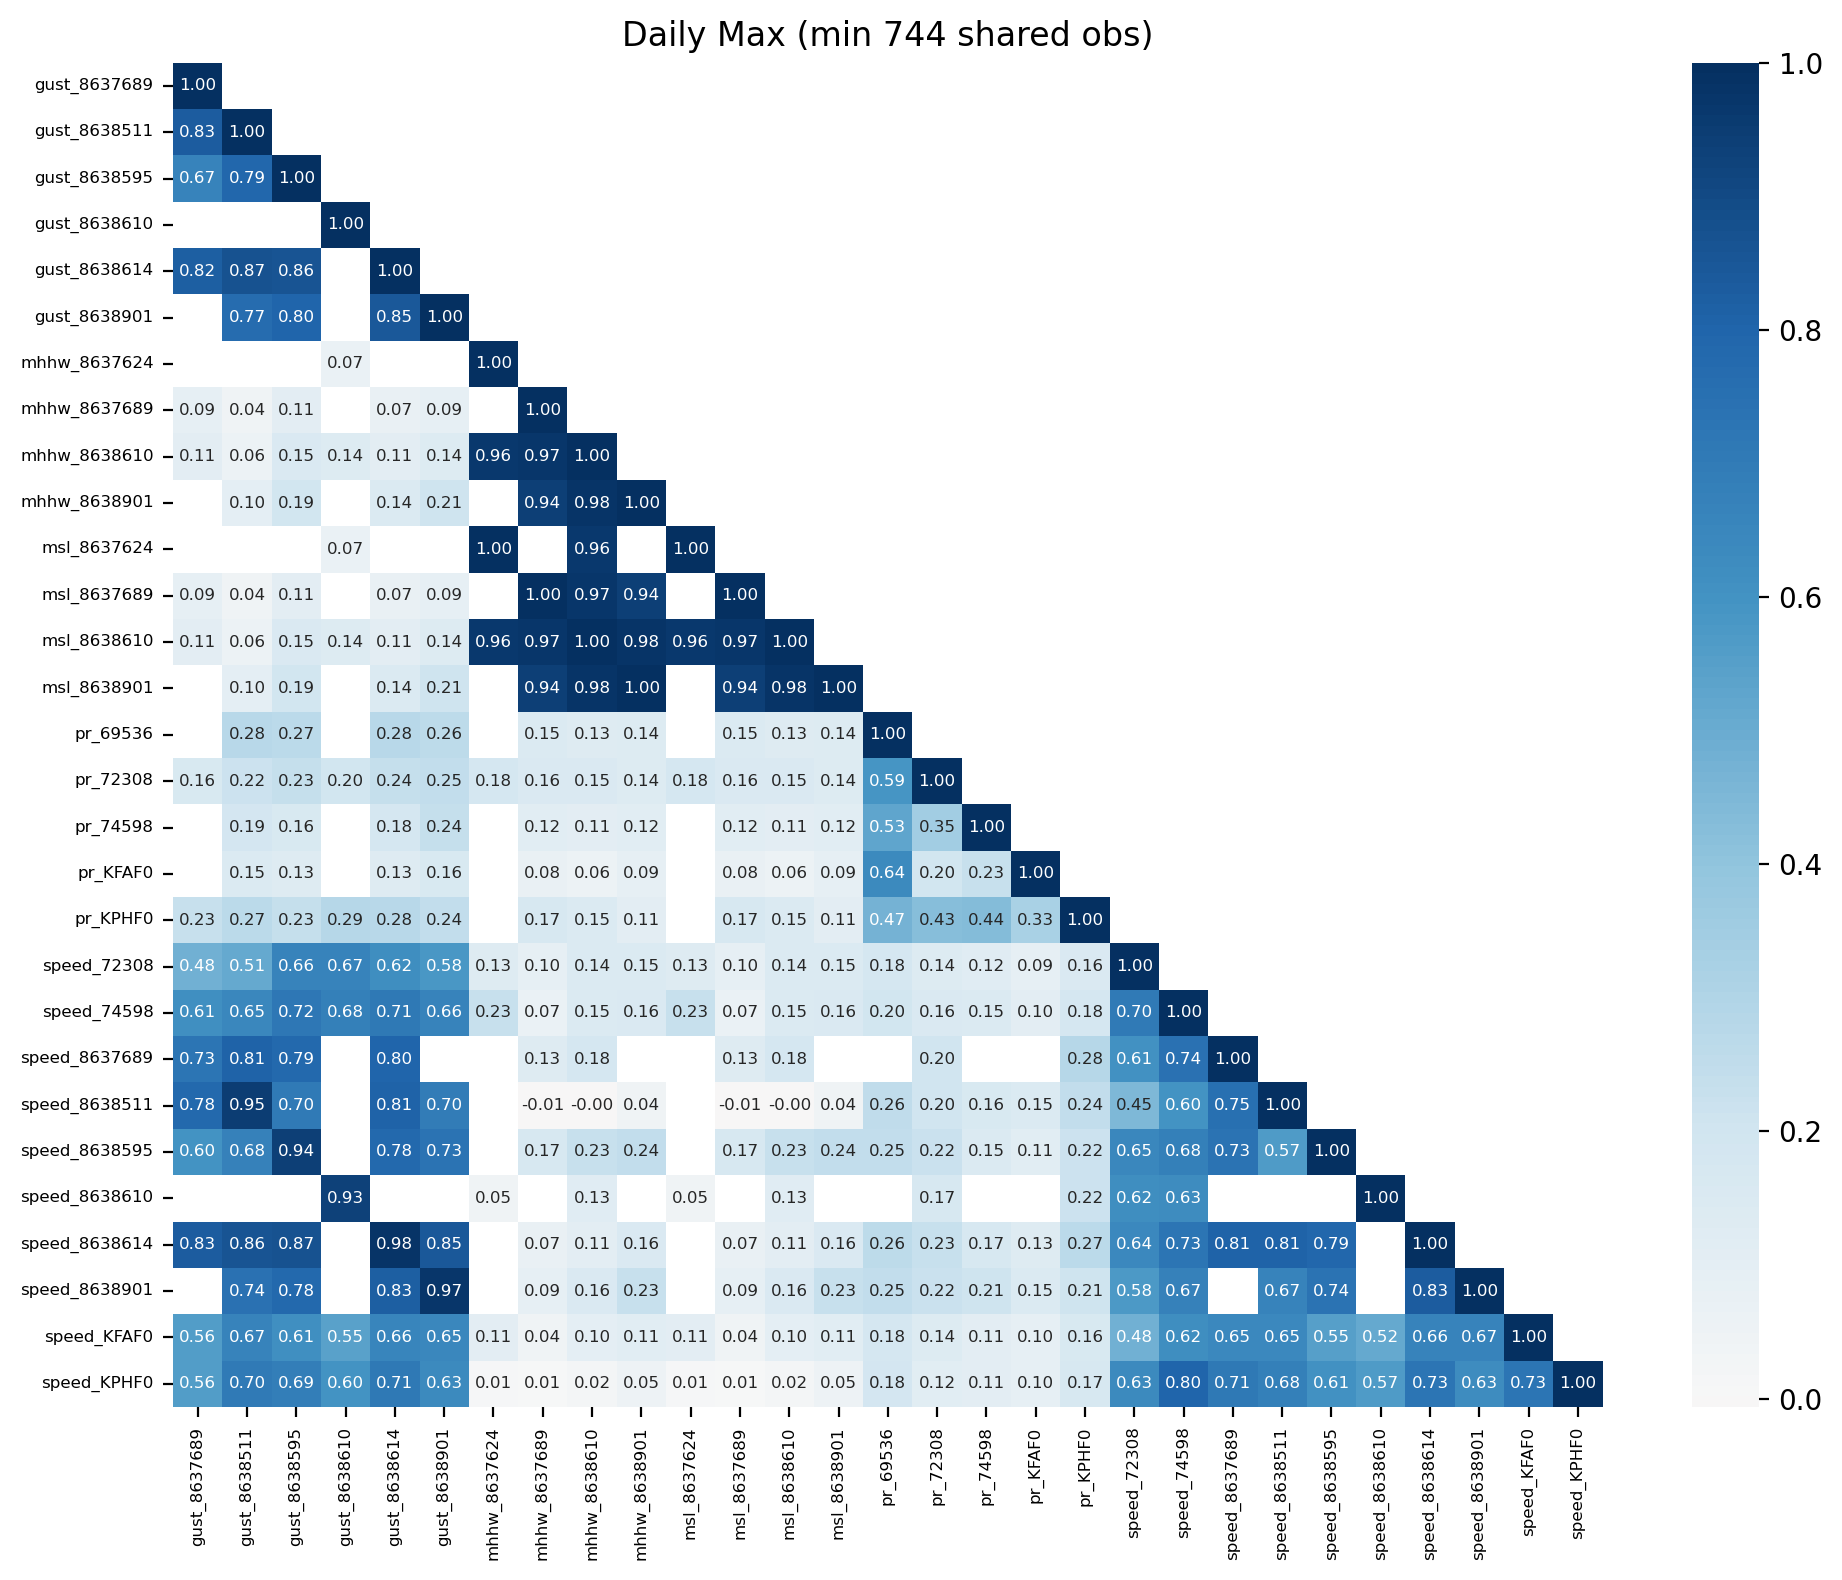

In [5]:
def plot_correlation_matrix(df, regex, title, res='h', min_shared_obs=100, 
                           cmap='RdBu', center=0, annot_size=6, label_size=6):
    resampled = df.filter(regex=regex).resample(res).max()
    non_na_counts = (~resampled.isna()).astype(int)
    shared_obs = non_na_counts.T @ non_na_counts
    insufficient_obs = shared_obs < min_shared_obs
    corr = resampled.corr()
    corr = corr.mask(insufficient_obs)
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', 
                cmap=cmap, center=center, annot_kws={'size': annot_size})
    plt.title(f'{title} (min {min_shared_obs} shared obs)')
    plt.xticks(fontsize=label_size) 
    plt.yticks(fontsize=label_size)
    plt.tight_layout()
    plt.show()
    
plot_correlation_matrix(df, r'speed_|gust_|msl_|mhhw_|pr_', 'Hourly', res='h', min_shared_obs=24*31*12)
plot_correlation_matrix(df, r'speed_|gust_|msl_|mhhw_|pr_', 'Daily Max', res='d', min_shared_obs=31*12*2)
# plot_correlation_matrix(df, r'speed_|gust_|msl_|mhhw_|pr_', 'Monthly Max', res='ME', min_shared_obs=12*3)

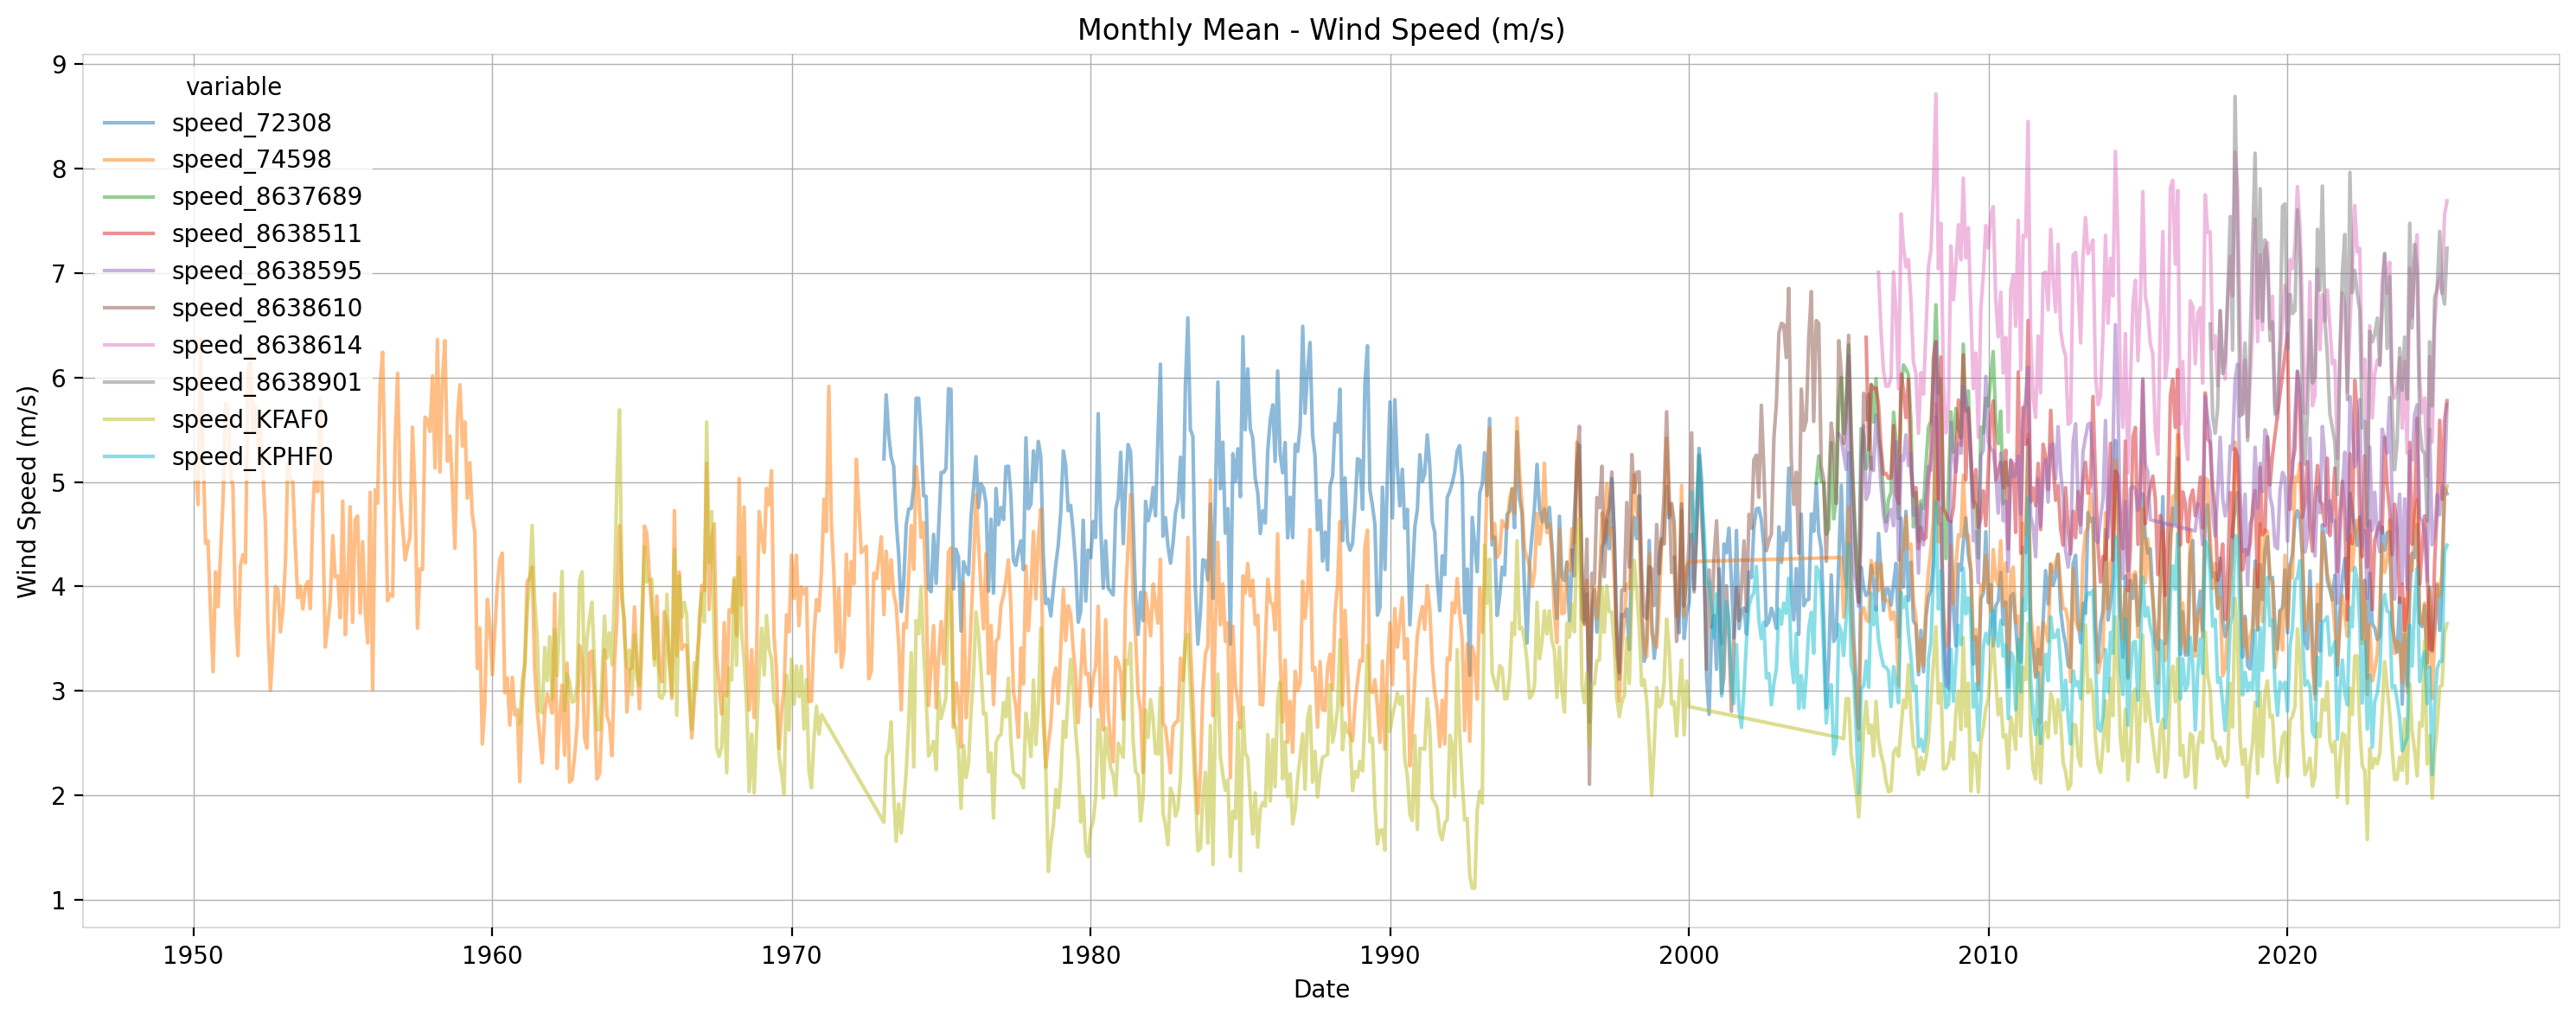

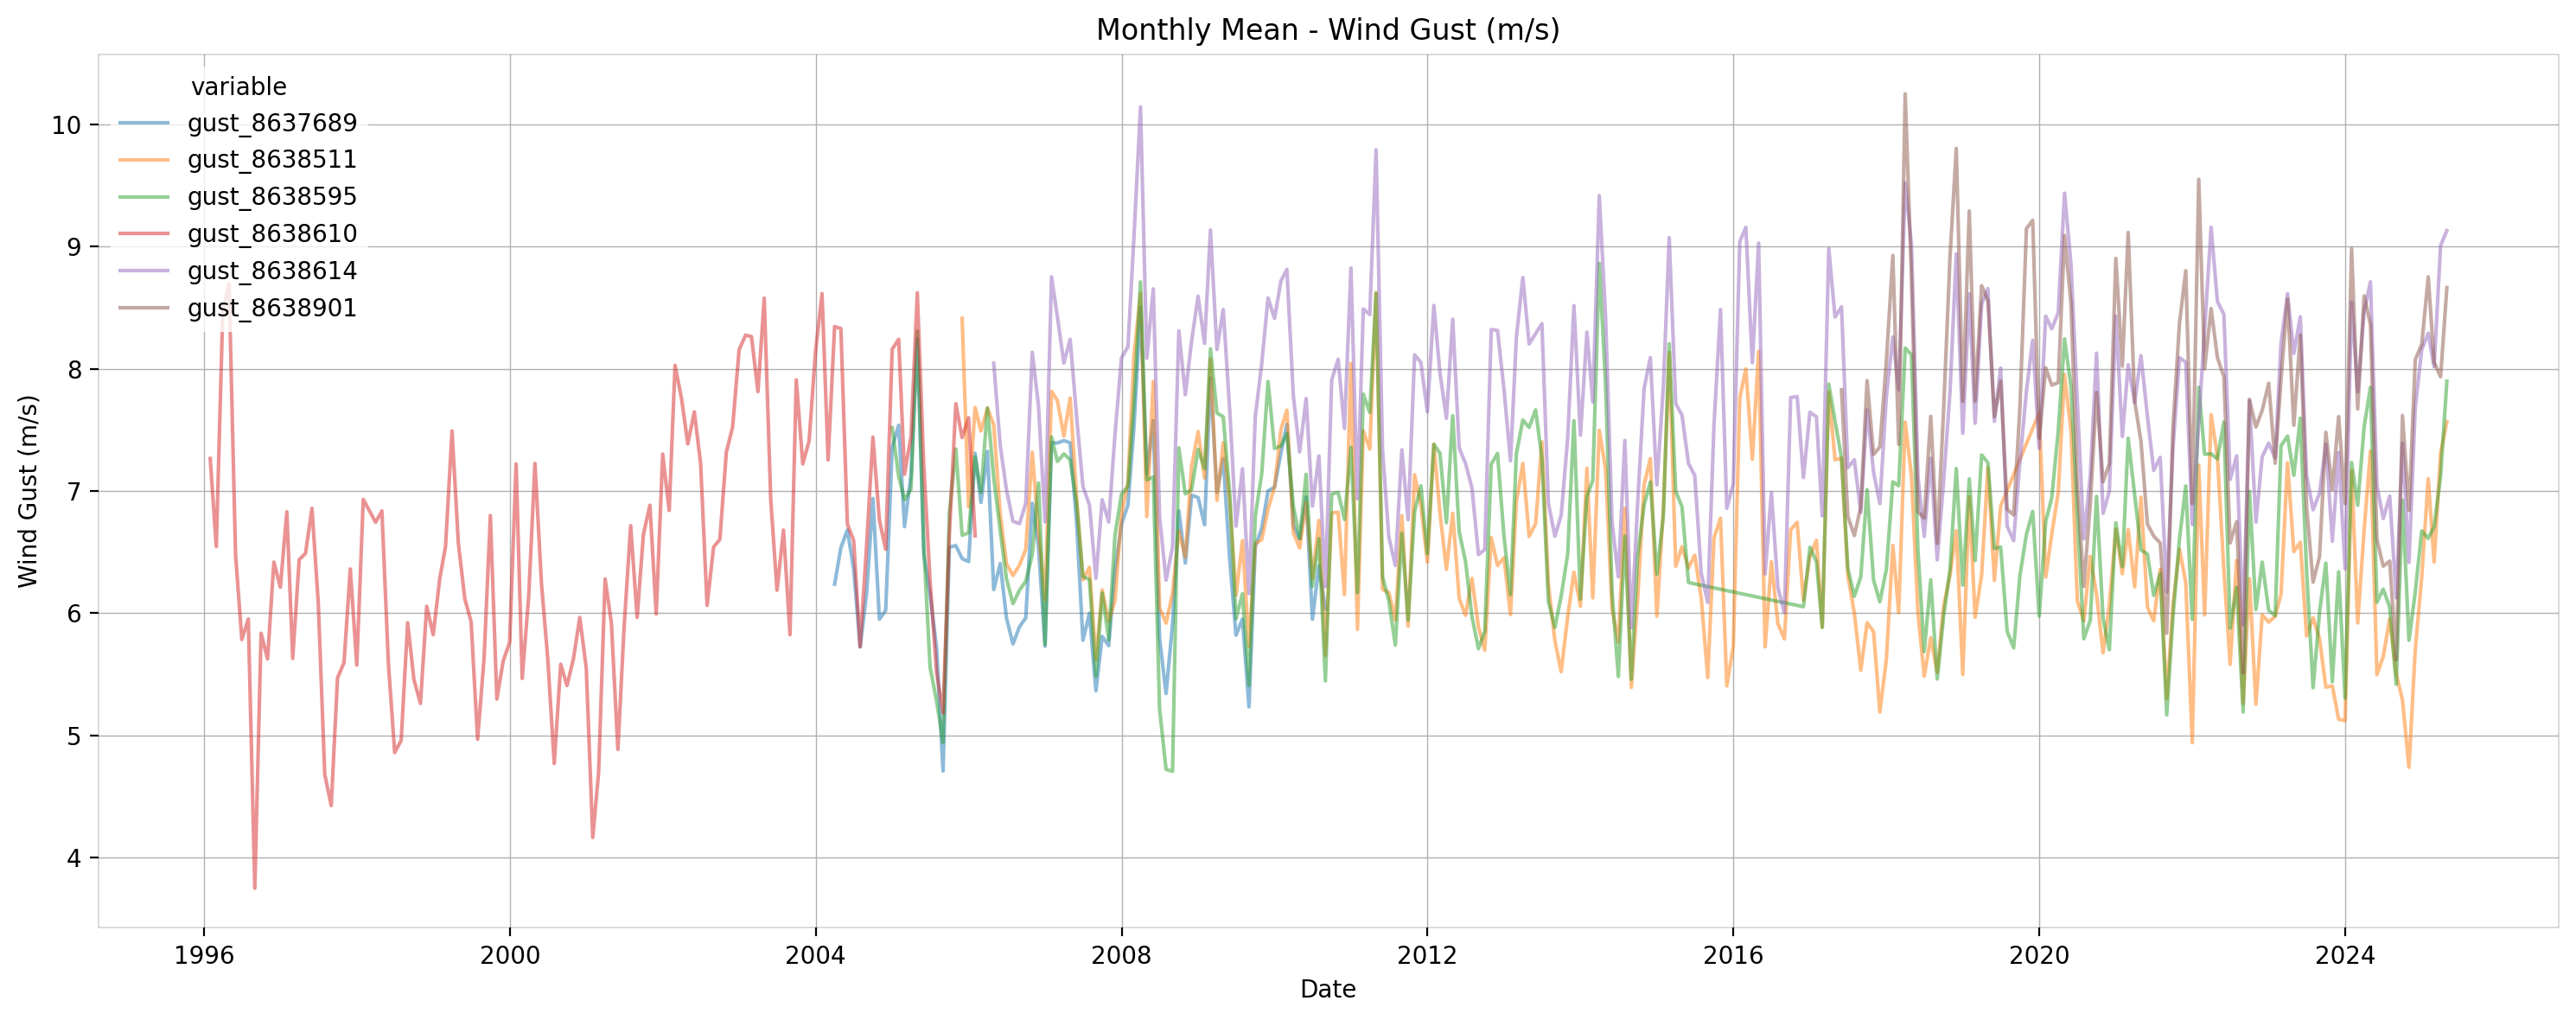

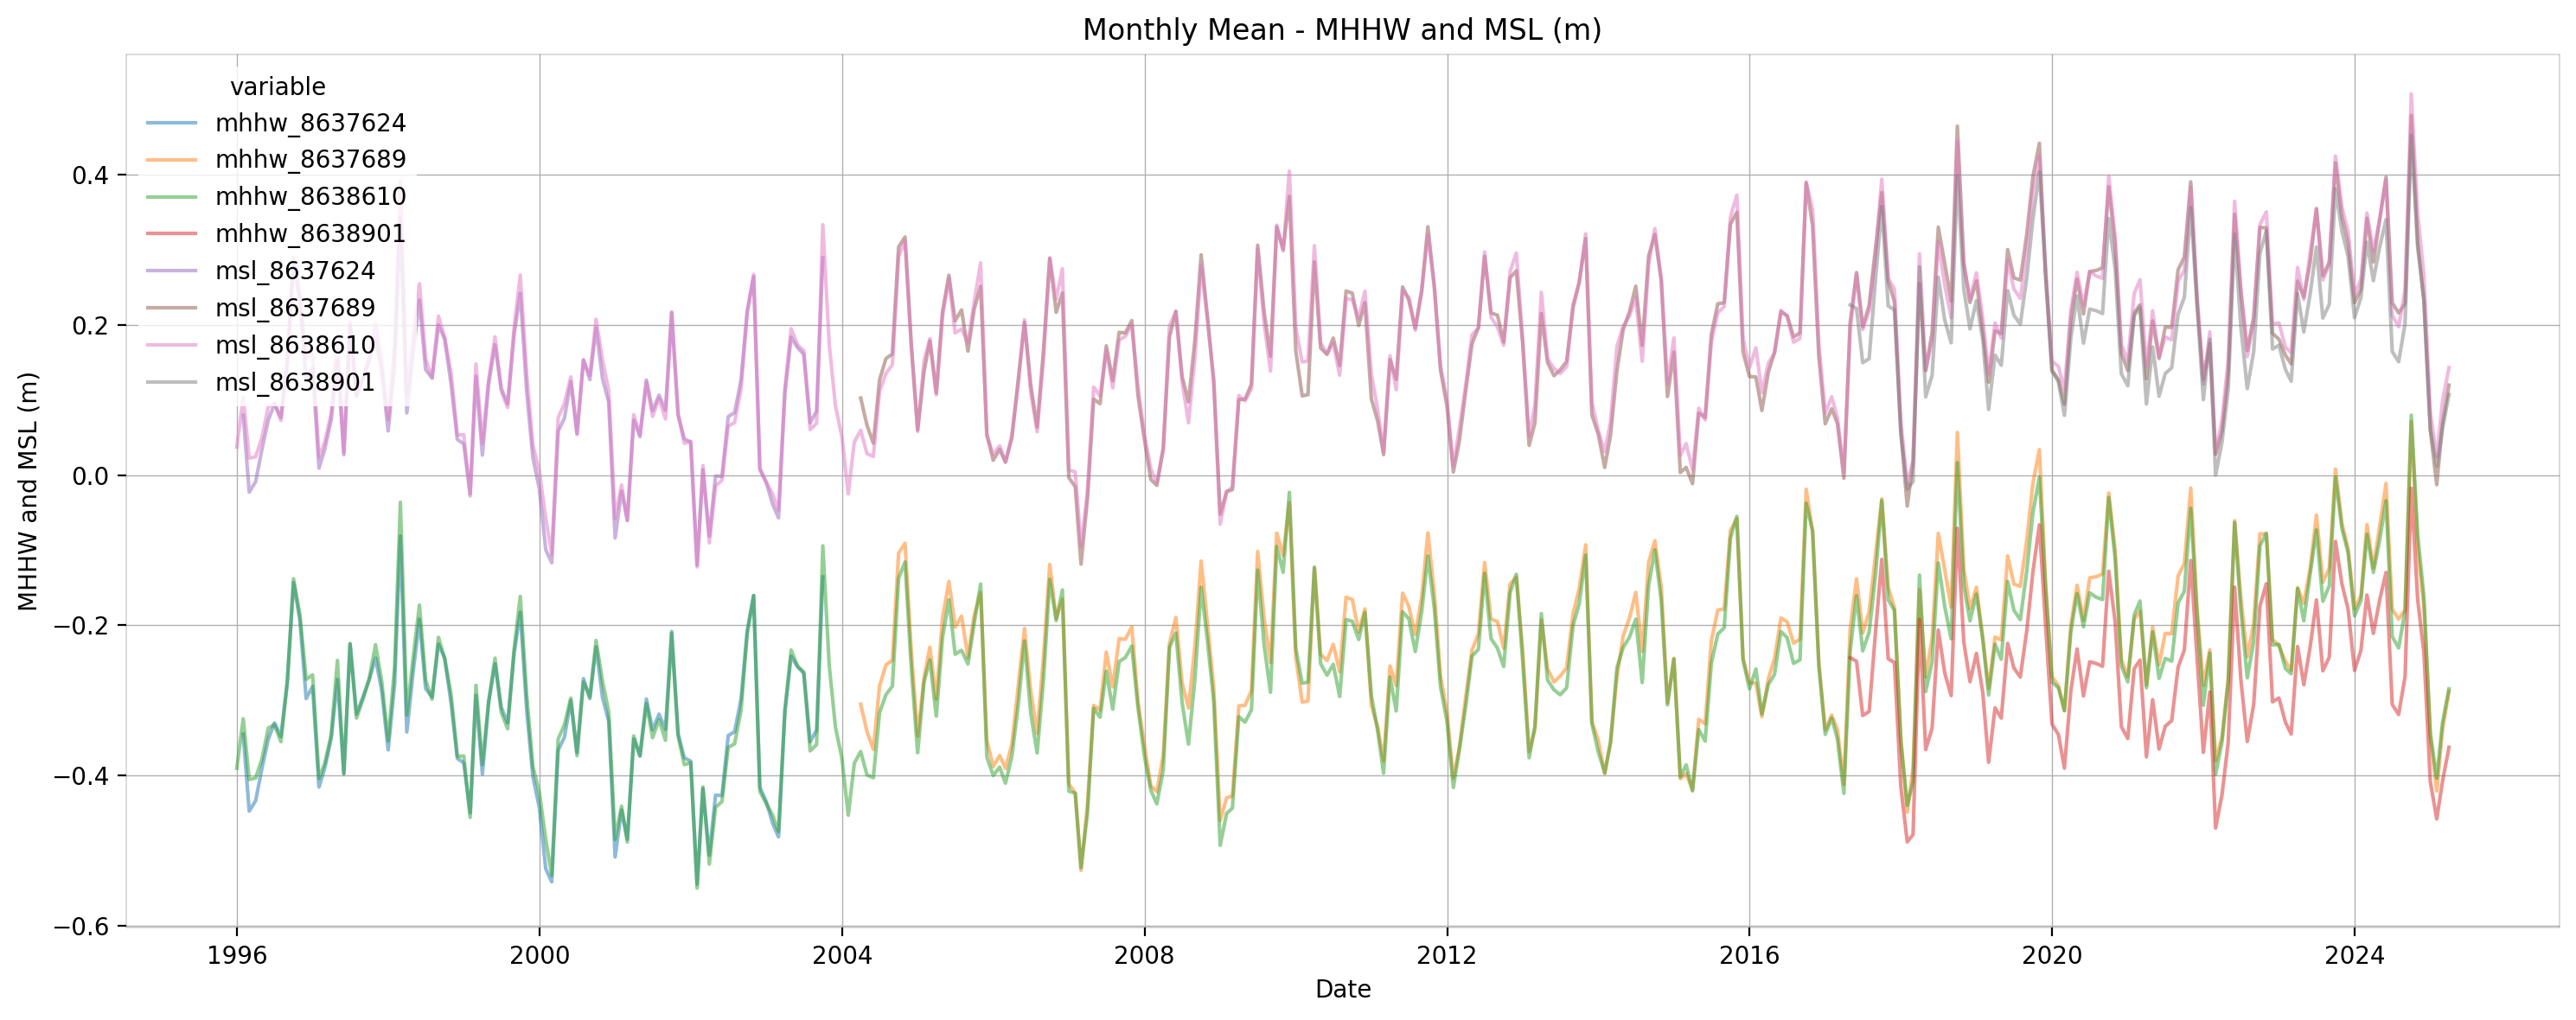

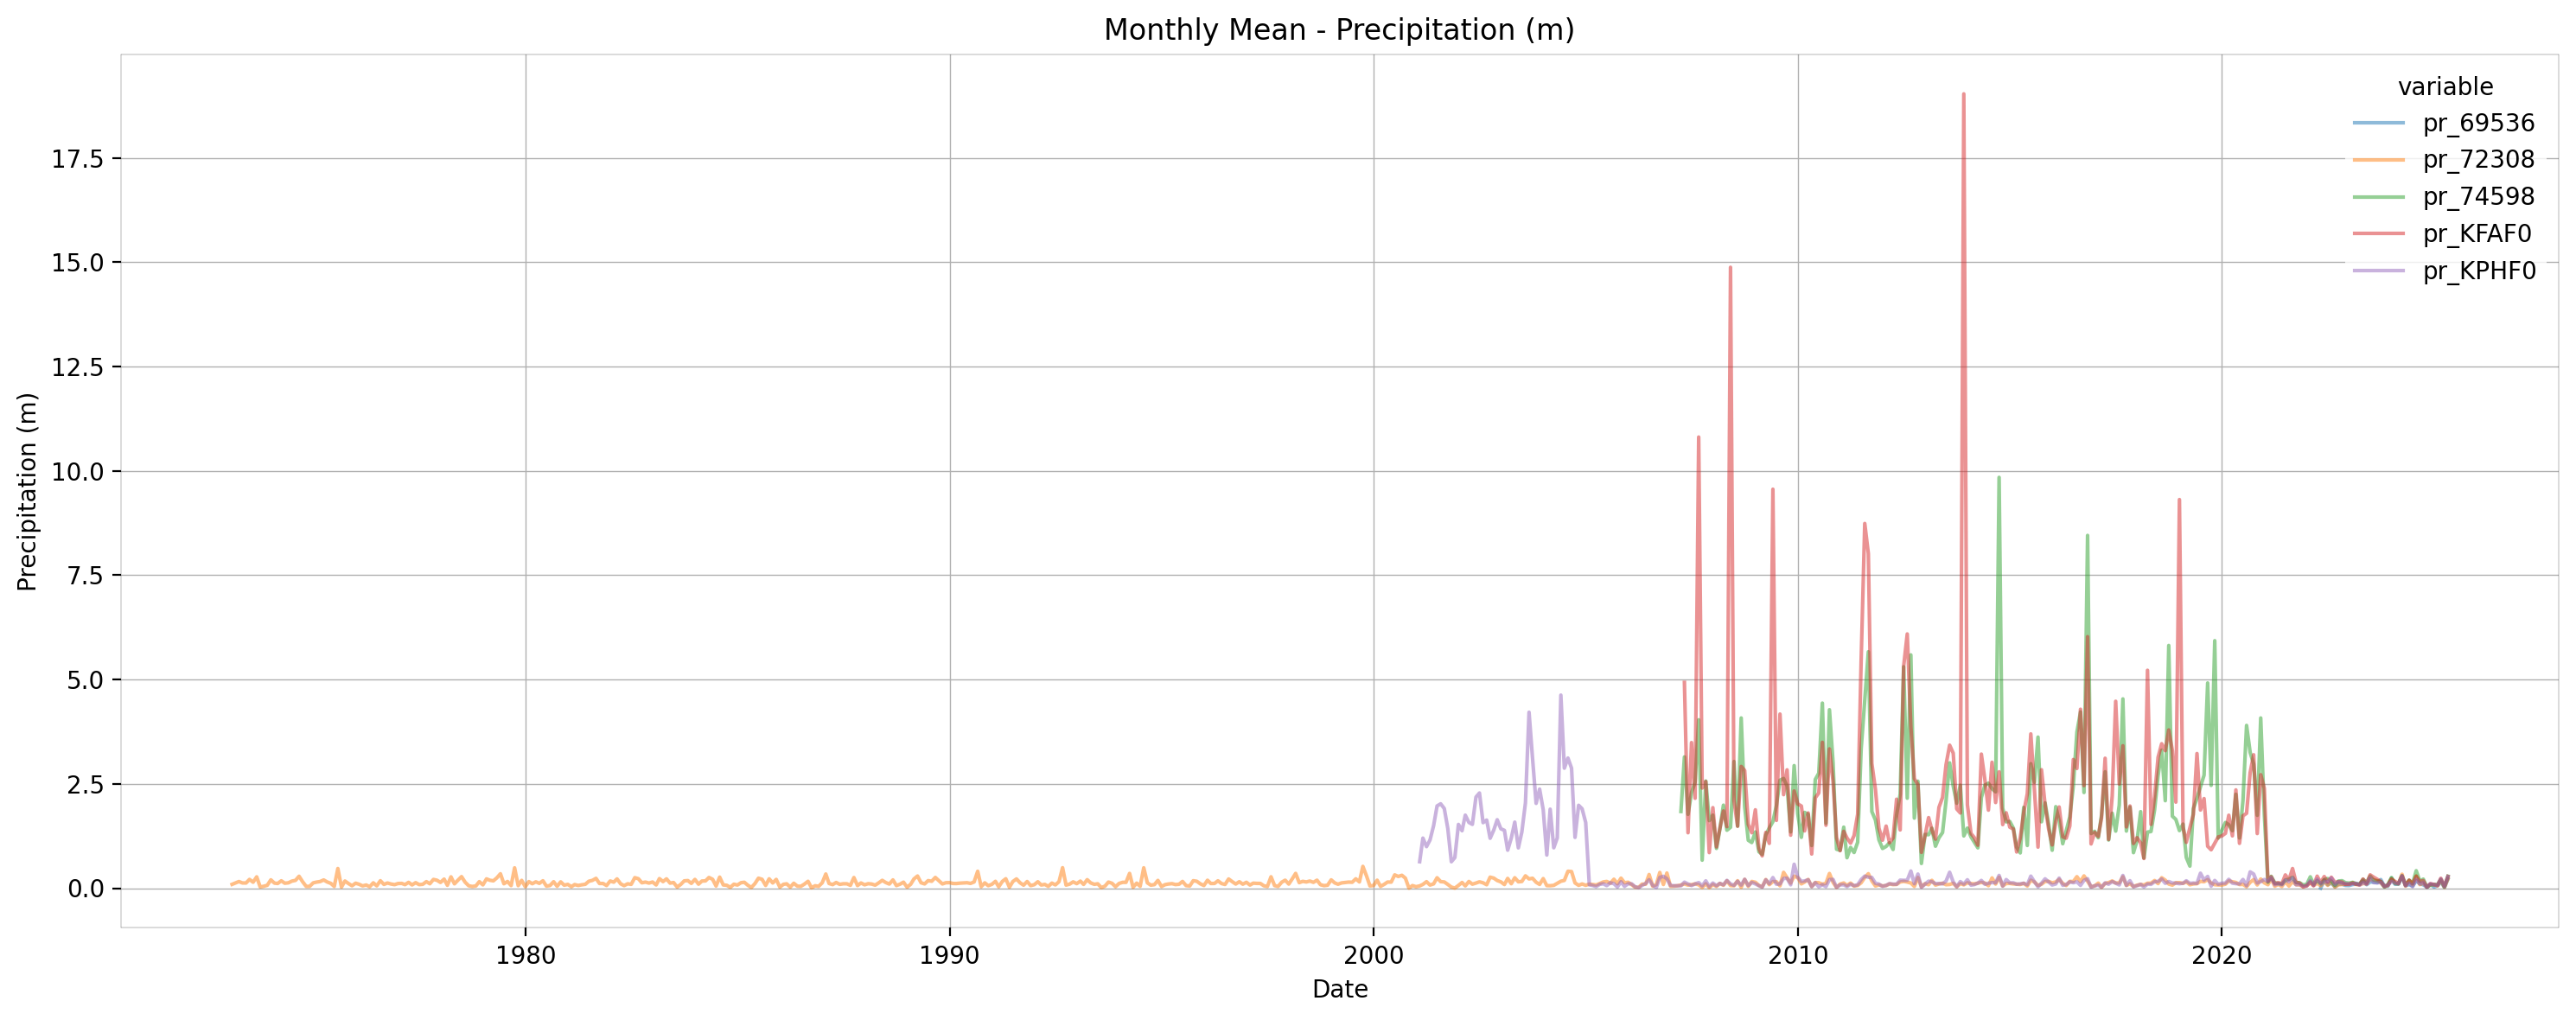

In [6]:
def plot_ts(df, var, label):
    monthly = df.filter(regex=var).resample('ME').mean().reset_index()
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=monthly.melt(id_vars='index', var_name='variable', value_name='value'),
                 x='index', y='value', hue='variable', alpha=0.5)

    plt.title(f'Monthly Mean - {label}')
    plt.xlabel('Date')
    plt.ylabel(label)
    plt.grid(True, linewidth=0.5)
    plt.tight_layout()
    plt.show()


var_map = {
    'speed_': 'Wind Speed (m/s)',
    'gust_': 'Wind Gust (m/s)',
    'mhhw_|msl_': 'MHHW and MSL (m)',
    'pr_': 'Precipitation (m)'
}

for var, label in var_map.items():
    plot_ts(df, var, label)

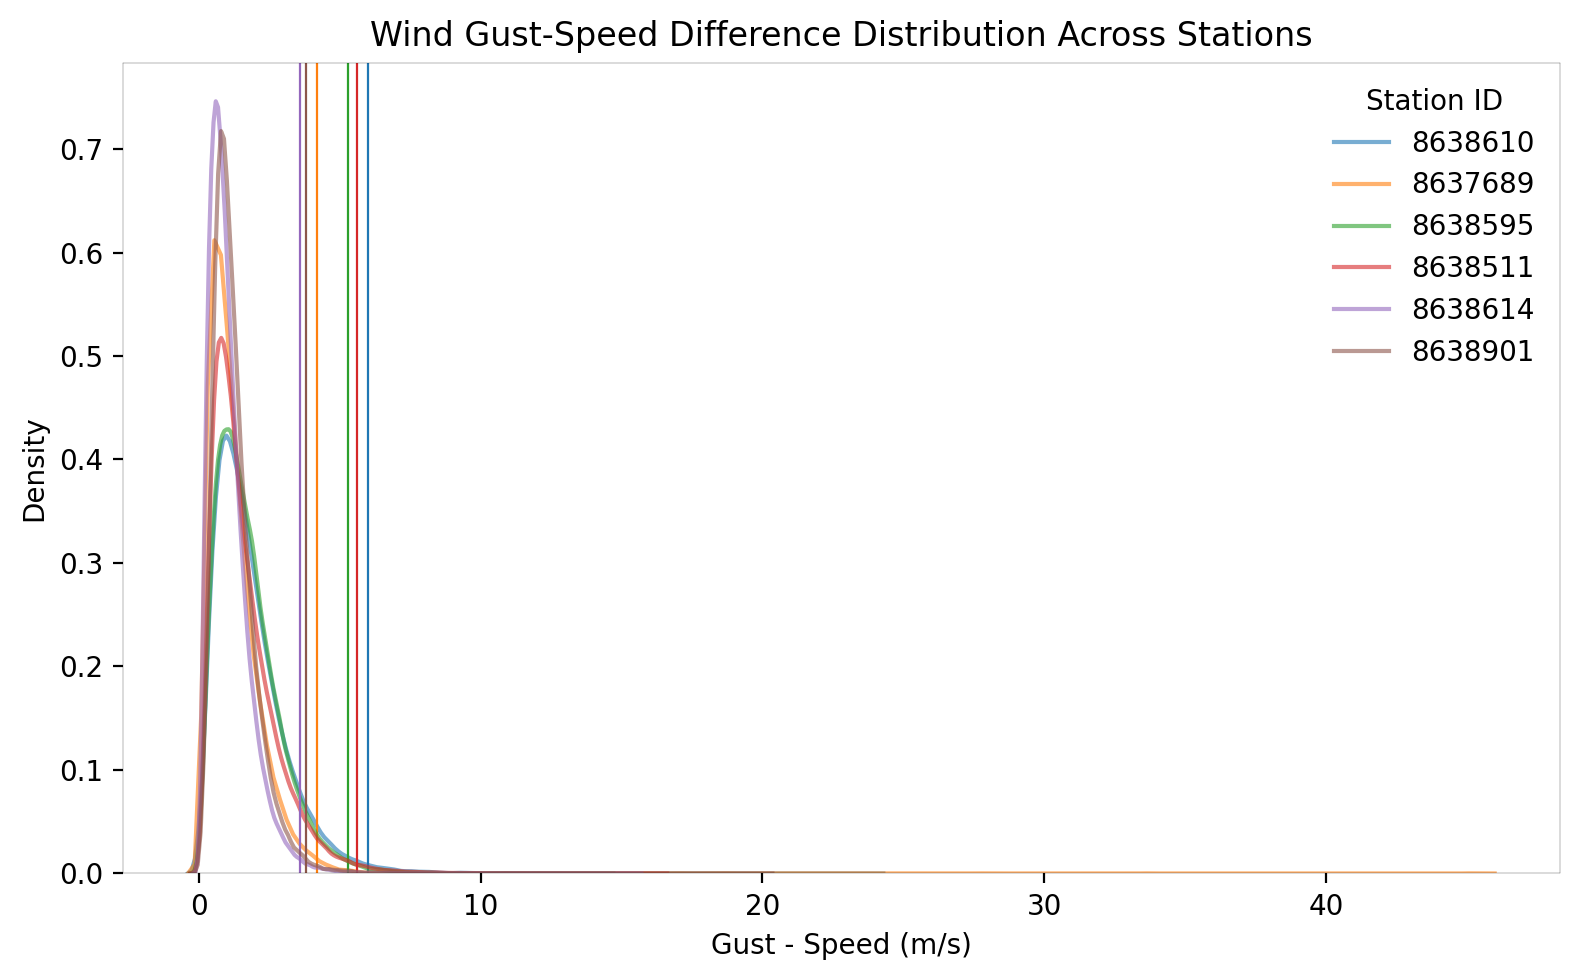

In [7]:
plt.figure(figsize=(8, 5))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, station_id in enumerate(wind_stations):
    diff = (wind_df[f'gust_{station_id}'] - wind_df[f'speed_{station_id}']).dropna()
    color = color_cycle[i % len(color_cycle)]
    sns.kdeplot(diff, label=str(station_id), alpha=0.6, color=color)
    plt.axvline(diff.quantile(0.99), linewidth=0.8, alpha=1, color=color)

plt.xlabel('Gust - Speed (m/s)')
plt.ylabel('Density')
plt.title('Wind Gust-Speed Difference Distribution Across Stations')
plt.legend(title='Station ID')
plt.tight_layout()
plt.show()

In [ ]:
station_id = 8638614
info = wind[wind.station_id == str(station_id)].iloc[0]
dd = wind_df.filter(regex=str(station_id)).dropna()
dd.columns = [c.split('_')[0] for c in dd.columns]
dd['diff'] = dd['gust'] - dd['speed']

dir_map = {d: i * 22.5 for i, d in enumerate(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                                              'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'])}
dd['angle'] = dd['dir'].map(dir_map)

for var in ['speed', 'diff']:
    q = dd[var].quantile([0, .2, .4, .6, .8, .95, .99, 1])
    dd[f'{var}_bin'] = pd.cut(dd[var], q, include_lowest=True, ordered=True)

def group(var): return dd.groupby(['angle', f'{var}_bin']).size().reset_index(name='frequency')

layout = dict(polar=dict(radialaxis=dict(showticklabels=True, ticks=''),
                         angularaxis=dict(showticklabels=True, tickmode='array',
                            tickvals=list(dir_map.values()), ticktext=list(dir_map.keys()))))
title = f'{info.station_name} {station_id} ({info.start_date.year}–{info.end_date.year}) - Wind'
configs = [('speed', 'Speed', px.colors.sequential.Viridis),
           ('diff', 'Gust-Speed Difference', px.colors.sequential.Plotly3)]
for var, label, colors in configs:
    fig = px.bar_polar(group(var), r='frequency', theta='angle', color=f'{var}_bin', title=f'{title} {label}', 
                       template='plotly_dark', color_discrete_sequence=colors, height=500)
    fig.update_layout(layout)
    fig.show()

# NWIS
### Stations near LaRC
- Not all stations have useful parameters
- Brick Kiln Creek Below Route 172 Near Poquoson, VA - 0167862550:
    - https://waterdata.usgs.gov/monitoring-location/0167862550/#dataTypeId=continuous-62620-0&period=P7D&showMedian=true
- Hampton River at Route 351 at Hampton, VA - 0204289985:
    - https://waterdata.usgs.gov/monitoring-location/0204289985/#dataTypeId=continuous-62620-0&period=P7D&showMedian=true
- James River at Fort Monroe, VA - 0204289994:
    - https://waterdata.usgs.gov/monitoring-location/0204289994/#dataTypeId=continuous-62620-0&period=P7D&showMedian=true
- Newmarket Creek at Mercury Blvd at Hampton, VA - 0167892964:
    - https://waterdata.usgs.gov/monitoring-location/0167892964/#dataTypeId=continuous-62620-0&period=P7D&showMedian=true
- Storm Drain at Coliseum Drive at Hampton, VA - 0167891721:
    - https://waterdata.usgs.gov/monitoring-location/0167891721/#dataTypeId=continuous-00065-0&period=P7D&showMedian=false
- Storm Drain West of Garrett Drive at Hampton, VA - 0167889257:
    - https://waterdata.usgs.gov/monitoring-location/0167889257/#dataTypeId=continuous-00065-0&period=P7D&showMedian=false
- 59D 25 Sow 213 - 365756076251201:
    - https://waterdata.usgs.gov/monitoring-location/365756076251201/#dataTypeId=continuous-72019-0&period=P7D&showMedian=true
### parameters
- https://doi-usgs.github.io/dataretrieval-python/examples/index.html
- https://help.waterdata.usgs.gov/parameter_cd?group_cd=PHY
    - 00061, 00035, 00036, 00045, ...
 


In [ ]:
import pandas as pd
from geopy.distance import geodesic
import dataretrieval.nwis as nwis

coord = (37.0862, -76.3809) # LaRC
param_codes = {
    '00061': 'Discharge',
    '00035': 'Wind Speed',
    '00036': 'Wind Direction',
    '00045': 'Precipitation'
}

results = []

for code, desc in param_codes.items():
    site_data, _ = nwis.what_sites(stateCd='VA', parameterCd=code)
    site_data = site_data.dropna(subset=['dec_lat_va', 'dec_long_va'])
    site_data['distance_km'] = site_data.apply(
        lambda row: geodesic(coord, (row['dec_lat_va'], row['dec_long_va'])).km, axis=1)
    nearest = site_data.sort_values('distance_km').head()
    nearest['param_code'] = code
    nearest['param_desc'] = desc
    results.append(nearest[['site_no', 'station_nm', 'dec_lat_va', 'dec_long_va', 'distance_km', 'param_code', 'param_desc']])

final_df = pd.concat(results).reset_index(drop=True)
display(final_df)


In [ ]:
# # first import the functions for downloading data from NWIS
# import dataretrieval.nwis as nwis

# # specify the USGS site code for which we want data.
# site = ['0167862550', '0204289985', '0167892964', '0167891721', '0167889257', '365756076251201']


# # get instantaneous values (iv)
# df = nwis.get_record(sites=site, service='iv', start='2017-12-31', end='2018-01-01')

# # get water quality samples (qwdata)
# # df2 = nwis.get_qwdata(sites=site)

# # get basic info about the site
# df3 = nwis.get_record(sites=site, service='site')

In [ ]:
# var = 'speed_8638610'
# df_speed = wind_df[[var]].copy().dropna()
# daily_df = df_speed.resample('ME').mean()
# daily_df['year'] = daily_df.index.year
# daily_df['month'] = daily_df.index.month
# plt.figure(figsize=(14, 8))
# sns.lineplot(data=daily_df, x='month', y=var, hue='year', palette='viridis', alpha=1)
# plt.title(f'{var} - Monthly Wind Speed')
# plt.xlabel('Month')
# plt.ylabel('Wind Speed')
# plt.grid(True, linewidth=0.5)
# plt.legend(title='Year')
# plt.tight_layout()
# plt.show()